# Loading and Merging NPI data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
import json
import copy

import re

In [3]:
# this dict contains information for loading the info
npi_information_dict = {
    'Public Outdoor Gathering Person Limit': {
        'type': 'value',
        'start_date_col': 'Start date (Public Outdoors)',
        'end_date_col': 'End date (Public Outdoors)',
        'value_col': 'Limit on number of people (only X people or fewer) (Public Outdoors)'
    },
    'Public Indoor Gathering Person Limit': {
        'type': 'value',
        'start_date_col': 'Start date (Public Indoors)',
        'end_date_col': 'End date (Public Indoors)',
        'value_col': 'Limit on number of people (only X people or fewer) (Public Indoors)'
    },
    'Private Outdoor Gathering Person Limit': {
        'type': 'value',
        'start_date_col': 'Start date (Private Outdoors)',
        'end_date_col': 'End date (Private Outdoors)',
        'value_col': 'Limit on number of people (only X people or fewer) (Private Outdoors)'
    },
    'Private Indoor Gathering Person Limit': {
        'type': 'value',
        'start_date_col': 'Start date (Private Indoors)',
        'end_date_col': 'End date (Private Indoors)',
        'value_col': 'Limit on number of people (only X people or fewer) (Private Indoors)'
    },
    'Public Outdoor Household Limit': {
        'type': 'value',
        'start_date_col': 'Start date (Public Outdoors)',
        'end_date_col': 'End date (Public Outdoors)',
        'value_col': 'Limit on number of households (Public Outdoors)'
    },
    'Public Indoor Household Limit': {
        'type': 'value',
        'start_date_col': 'Start date (Public Indoors)',
        'end_date_col': 'End date (Public Indoors)',
        'value_col': 'Limit on number of households (Public Indoors)'
    },
    'Private Outdoor Household Limit': {
        'type': 'value',
        'start_date_col': 'Start date (Private Outdoors)',
        'end_date_col': 'End date (Private Outdoors)',
        'value_col': 'Limit on number of households (Private Outdoors)'
    },
    'Private Indoor Household Limit': {
        'type': 'value',
        'start_date_col': 'Start date (Private Indoors)',
        'end_date_col': 'End date (Private Indoors)',
        'value_col': 'Limit on number of households (Private Indoors)'
    },
    'Mandatory Mask Wearing': {
        'type': 'value',
        'start_date_col': 'Start date (Mask Wearing)',
        'end_date_col': 'End date (Mask Wearing)',
        'value_col': 'Level of NPI (0-4) (Mask Wearing)'
    },
    'Some Face-to-Face Businesses Closed': {
        'type': 'binary',
        'start_date_col': 'Start date (Some Face2Face)',
        'end_date_col': 'End date (Some Face2Face)'
    },
    'Gastronomy Closed': {
        'type': 'binary',
        'start_date_col': 'Start date  (Gastronomy Closed)',
        'end_date_col': 'End date (Gastronomy Closed)'
    },
    'Leisure Venues Closed': {
        'type': 'binary',
        'start_date_col': 'Start date (Leisure Venue)',
        'end_date_col': 'End date (Leisure Venue)'
    },
    'Retail Closed': {
        'type': 'binary',
        'start_date_col': 'Start date (Retail)',
        'end_date_col': 'End date (Retail)'
    },
    'All Face-to-Face Businesses Closed': {
        'type': 'binary',
        'start_date_col': 'Start date (All Face2Face)',
        'end_date_col': 'End date (All Face2Face)'
    },
    'Stay at Home Order': {
        'type': 'binary',
        'start_date_col': 'Start date (Stay Home)',
        'end_date_col': 'End date (Stay Home)'
    },
    'Curfew': {
        'type': 'binary',
        'start_date_col': 'Start date (Curfew)',
        'end_date_col': 'End date (Curfew)'
    },
    'Childcare Closed': {
        'type': 'binary',
        'start_date_col': 'Start date (Childcare)',
        'end_date_col': 'End date  (Childcare)'
    },
    'Primary Schools Closed': {
        'type': 'binary',
        'start_date_col': 'Start date (Primary Schools)',
        'end_date_col': 'End date (Primary Schools)'
    },
    'Secondary Schools Closed': {
        'type': 'binary',
        'start_date_col': 'Start date (Secondary Schools)',
        'end_date_col': 'End date (Secondary Schools)'
    },
    'Universities Away': {
        'type': 'binary',
        'start_date_col': 'Start date (Unis Away)',
        'end_date_col': 'End date (Unis Away)'
    },
}

In [4]:
# if there is a string, this lookup converts the month string into the month int and year int
# not the cleanest way of doing this....
lookup_months = {
    'January': (1, 2021),
    'Jan': (1, 2021),
    'September': (9, 2020),
    'Septemeber': (9, 2020),
    'December': (12, 2020),
    'August': (8, 2020),
    'November': (11, 2020),
}

In [26]:
def process_start_date_str(start_date_str):
    if start_date_str.strip() in ['Before 1 August', 'before 1 August 2020', 'Before 1 August 2020', 'Before August 1', '1 August 2020', 'Before 1st of August', 'before 01/08/2020', 'before 1/08/2020',  
                                  'before 1/8/2020', 'before 13/7/2020', 'Before 1st August', 'Before 01/08/2020']:
        return pd.to_datetime('2020-08-01')
    
    elif start_date_str.strip() in ['no', 'No', 'nan', 'N/A', 'NA']:
        return None
    
    try:
        return pd.to_datetime(start_date_str, dayfirst=True, infer_datetime_format=True)
    except ValueError:
        day = int(re.search('[0-9]+', start_date_str)[0])
        for month_str, (m, y) in lookup_months.items():
            if month_str in start_date_str:
                dt = pd.Timestamp(day=day, month=m, year=y)
                print(f'Regex Succeeded: Converted {start_date_str} to {dt}')
                return dt
        print(f'Problem: Could not convert start date {start_date_str}')
        
def process_end_date_str(end_date_str):
    if end_date_str.strip() in ['no', 'No', 'nan', 'N/A', 'NA', '-', 'After 9 January 2021']:
        return pd.to_datetime('2021-01-09')

    try:
        return pd.to_datetime(end_date_str,  dayfirst=True, infer_datetime_format=True)
    except ValueError:
        #print(end_date_str)
        day = int(re.search('[0-9]+', end_date_str)[0])
        for month_str, (m, y) in lookup_months.items():
            if month_str in end_date_str:
                dt = pd.Timestamp(day=day, month=m, year=y)
                print(f'Regex Succeeded: Converted {end_date_str} to {dt}')
                return dt
        
        print(f'Problem: Could not convert end date {end_date_str}')

        
def process_value(value):
    if str(value).strip() in ['no', 'No', 'nan', 'NaN']:
        return 0
    if ',' in str(value):
        value = value.replace(',','')
    return int(value)
        
def process_cm_dict(row, cm_dict):
    sd = str(row[cm_dict['start_date_col']])
    ed = str(row[cm_dict['end_date_col']])

    sd_dt = process_start_date_str(sd)
    ed_dt = process_end_date_str(ed)

    if sd_dt is None:
        return (None, None, None)
    else:
        # sd is not None
        value = 1 if cm_dict['type'] == 'binary' else process_value(row[cm_dict['value_col']])
        return (sd_dt, ed_dt, value)
        
def datetime_to_index(dt, Ds, r, cm_name, final):
    ind = None
    
    if dt < pd.to_datetime('2020-08-01'):
        if dt < pd.to_datetime('2020-07-01'):
            print(f'Date {dt} is before 1st July. Region: {r}, CM: {cm_name}. Setting to Aug 1st')
        ind = 0
    else:
        try:
            ind = list(Ds).index(dt)
        except:
            if final == False:
                print(f'Problem: Date {dt} is after 9th Jan. Region: {r}, CM: {cm_name}. Setting index to None')
                return ind
            else:
                error_str = f'Date {dt} was not in my list'
                new_dt = dt - pd.DateOffset(years=1)
                if new_dt in Ds:
                    ind = list(Ds).index(new_dt)
                    error_str = f'{error_str} -- Used month and date'
                else:
                    error_str = f'Problem: {error_str} -- failed'
                print(error_str)
    return ind


In [23]:
# def create_active_cms_mat(df, Rs, npi_information_dict, Ds):
#     CMs = list(npi_information_dict.keys())
#
#     nRs = len(Rs)
#     nDs = len(Ds)
#     nCMs = len(CMs)
#
#     active_cms = np.zeros((nRs, nCMs, nDs))
#
#     for r_i, r in enumerate(Rs):
#         sub_df = df.loc[r]
#         for _, row in sub_df.iterrows():
#             for cm_i, (cm_name, cm_dict) in enumerate(npi_information_dict.items()):
#                 sd_dt, ed_dt, value = process_cm_dict(row, cm_dict)
#
#                 if sd_dt is not None and ed_dt is not None:
#                     start_ind = datetime_to_index(sd_dt, Ds, r, cm_name)
#                     end_ind = datetime_to_index(ed_dt, Ds, r, cm_name)
#                     if start_ind is None:
#                         print(f'Problem with start date: {sd_dt} for {cm_name} in {r}')
#                     if end_ind is None:
#                         print(f'Problem with end date: {ed_dt} for {cm_name} in {r}')
#                     if start_ind is not None and end_ind is not None:
#                         if start_ind > end_ind:
#                             print(f'Problem with start-end date pair: [{Ds[start_ind]},{Ds[end_ind]}] for {cm_name} in {r}')
#                     # the NPI should be active on the end date. that's why we need the "+1"
#                     active_cms[r_i, cm_i, start_ind:end_ind+1] = value
#     return active_cms
#

def create_active_cms_mat(df, Rs, npi_information_dict, Ds, final=True):
    CMs = list(npi_information_dict.keys())

    nRs = len(Rs)
    nDs = len(Ds)
    nCMs = len(CMs)

    active_cms = np.zeros((nRs, nCMs, nDs))

    for r_i, r in enumerate(Rs):
        sub_df = df.loc[r]
        for cm_i, (cm_name, cm_dict) in enumerate(npi_information_dict.items()):
            old_end_ind = 0
            for _, row in sub_df.iterrows():
                sd_dt, ed_dt, value = process_cm_dict(row, cm_dict)
                if sd_dt is not None and ed_dt is not None:
                    start_ind = datetime_to_index(sd_dt, Ds, r, cm_name, final)
                    end_ind = datetime_to_index(ed_dt, Ds, r, cm_name, final)
                    if start_ind is None:
                        print(f'Problem with start date: {sd_dt} for {cm_name} in {r}')
                    else:
                        if old_end_ind is not None:
                            if start_ind < old_end_ind:
                                print(f'Problem: start date is before the end date of the previous row on {sd_dt} for {cm_name} in {r}')
                    if end_ind is None:
                        print(f'Problem with end date: {ed_dt} for {cm_name} in {r}')
                        end_ind = len(Ds) - 1

                    if start_ind is not None and end_ind is not None:
                        if start_ind > end_ind:
                            print(f'Problem with start-end date pair: [{Ds[start_ind]},{Ds[end_ind]}] for {cm_name} in {r}')
                    # the NPI should be active on the end date. that's why we need the "+1"
                    active_cms[r_i, cm_i, start_ind:end_ind+1] = value
                    old_end_ind = end_ind
    return active_cms

def load_new_cases_deaths_from_timeseries_df(Rs, timeseries_df, Ds):
    new_cases = np.zeros((len(Rs), len(Ds)))
    new_deaths = np.zeros((len(Rs), len(Ds)))

    for r_i, r in enumerate(Rs):
        new_cases[r_i, :] = timeseries_df.loc[r].loc[Ds]['new_cases']
        new_deaths[r_i, :] = timeseries_df.loc[r].loc[Ds]['new_deaths']

    return new_cases, new_deaths

In [6]:
# Load all data

## UK

In [7]:
# currently reads directly from the CSV
uk_df = pd.read_csv('../../data/npi_data/england.csv', skiprows=2).dropna(axis='index', how='all')#.set_index('Code')
droplist = [c for c in uk_df.columns if 'Sources' in c or 'Quotes' in c or 'Description' in c or 'What is the reason' in c or 'How many' in c or 'Unnamed' in c]
# droplist.extend(['Person who entered this row', 'At any point in time, did the local area ever implement NPIs of interest in only some part of the local area. If yes, describe the situation a bit more.',
#        'Would it be very easy to collect further data on neighboring local areas? If yes, for which local areas?',
#        'How long did you need to collect this data?'])

uk_df = uk_df.drop(droplist, axis=1)
uk_df = uk_df.rename(columns=lambda x: x.strip())
uk_df['Local area'] = uk_df['Local area'].apply(lambda x: str(x).strip())

uk_df = uk_df.set_index('Local area')

In [8]:
uk_Rs = ['Lincolnshire', 'Greater Manchester South West',
       'Redbridge and Waltham Forest', 'Enfield', 'Buckinghamshire CC',
       'Portsmouth', 'Southampton', 'Brighton and Hove', 'Coventry',
       'Walsall', 'North Yorkshire CC', 'Essex Haven Gateway',
       'Southend-on-Sea', 'Gloucestershire', 'East Derbyshire']

In [9]:
start_date = '08-01-2020'
end_date = '01-09-2021'
Ds = pd.date_range(start=start_date, end=end_date)

In [10]:
uk_active_cms = create_active_cms_mat(uk_df, uk_Rs, npi_information_dict, Ds, final=True)

In [11]:
with open('../../data/raw_data_w_sources/uk_ltla_info.json') as json_file:
    uk_ltla_info_dict = json.load(json_file)

uk_ltla_info_df = pd.DataFrame([d['attributes'] for d in uk_ltla_info_dict['features']])
uk_ltla_info_df = uk_ltla_info_df.rename({'LAU117NM': 'area', 'NUTS318NM': 'NUTS3', 'NUTS118NM': 'region'} ,axis=1)
uk_ltla_info_df = uk_ltla_info_df.set_index('area')

uk_df = pd.read_csv('../../data/raw_data_w_sources/uk_case_deaths.csv', infer_datetime_format=True)
uk_df = uk_df.drop(['areaCode', 'newCasesByPublishDate', 'newDeaths28DaysByPublishDate'], axis=1)
uk_df['areaType'] = 'UK'
uk_df = uk_df.rename({'areaType': 'country', 'areaName':'area', 'newCasesBySpecimenDate': 'new_cases', 'newDeaths28DaysByDeathDate': 'new_deaths'}, axis=1)
uk_df = uk_df.set_index(['area', 'date'])

def NUTS3_lookup(ltla):
    try:
        nuts3 = uk_ltla_info_df.loc[ltla]['NUTS3']
    except KeyError:
#         print(f'{ltla} missing in my lookup table')
        nuts3 = 'unknown'
    return nuts3

nuts3_uk_df = uk_df.reset_index()
nuts3_uk_df['NUTS3'] = nuts3_uk_df['area'].map(NUTS3_lookup)
days = nuts3_uk_df['date'].unique()
nuts3_regions = nuts3_uk_df['NUTS3'].unique()
nuts3_df_list = []
nuts3_uk_df_merged = None

for nuts3_region in nuts3_regions:
    if nuts3_region == 'unknown':
        continue
    
    filtered_df = nuts3_uk_df.loc[nuts3_uk_df['NUTS3'] == nuts3_region]
    
    case_death_series = filtered_df.groupby('date').sum()
    case_death_series['area'] = nuts3_region
    
    if nuts3_uk_df_merged is None:
        nuts3_uk_df_merged = copy.deepcopy(case_death_series)
    else:
        nuts3_uk_df_merged = nuts3_uk_df_merged.append(case_death_series)
    
nuts3_uk_df_merged = nuts3_uk_df_merged.reset_index()
nuts3_uk_df_merged['date'] = pd.to_datetime(nuts3_uk_df_merged['date'])
nuts3_uk_df_merged = nuts3_uk_df_merged.set_index(['area', 'date'])
nuts3_uk_df_merged = nuts3_uk_df_merged.sort_index(level=[1],ascending=[True])

In [12]:
uk_cases, uk_deaths = load_new_cases_deaths_from_timeseries_df(uk_Rs, nuts3_uk_df_merged, Ds)

## Austria

In [13]:
# currently reads directly from the CSV
at_df = pd.read_csv('../../data/npi_data/austria.csv', skiprows=2).dropna(axis='index', how='all')#.set_index('Code')
droplist = [c for c in at_df.columns if 'Sources' in c or 'Quotes' in c or 'Description' in c or 'What is the reason' in c or 'How many' in c or 'Unnamed' in c]
# droplist.extend(['Person who entered this row', 'At any point in time, did the local area ever implement NPIs of interest in only some part of the local area. If yes, describe the situation a bit more.',
#        'Would it be very easy to collect further data on neighboring local areas? If yes, for which local areas?',
#        'How long did you need to collect this data?', 'Local area'])

at_df = at_df.drop(droplist, axis=1)
at_df = at_df.rename(columns=lambda x: x.strip())

at_df = at_df.set_index('Region')

at_Rs = ['Wien', 'Burgenland', 'Steiermark', 'Oberösterreich',
       'Nieder­österreich', 'Voralberg ', 'Tirol', 'Karnten/Carinthia',
       'Salzburg']

In [14]:
at_active_cms = create_active_cms_mat(at_df, at_Rs, npi_information_dict, Ds, final=True)

In [15]:
austria_ltla_lookup = pd.read_csv('../../data/raw_data_w_sources/at_lau_lookup.csv')
austria_ltla_lookup = austria_ltla_lookup.set_index('GKZ')

def at_ltla_lookup(ltla):
    if ltla in austria_ltla_lookup.index:
        return austria_ltla_lookup.loc[ltla]['State Code (middle column of HASC)']
    return 'Vienna'

austria_df = pd.read_csv('../../data/raw_data_w_sources/at_case_deaths.csv', error_bad_lines=False, delimiter=';', skiprows=1)
austria_df = austria_df.drop([' number of cases total',
       ' number of cases of 7 days', ' seven days of incidence cases',' number of total totals',
       ' number of held daily', ' number of healing total'], axis=1)
austria_df[' GKZ'] = austria_df[' GKZ'].map(at_ltla_lookup)
austria_df = austria_df.rename({'Time': 'date', ' district': 'area', ' GKZ': 'region', ' number of inhabitants': 'population', ' number of cases': 'new_cases', ' number of dead daily': 'new_deaths'}, axis=1)
austria_df = austria_df.drop('population', axis=1)
austria_df['date'] = pd.to_datetime(austria_df['date'], format='%d.%m.%Y %M:%H:%S')

austria_timeseries_df = austria_df.set_index(['area', 'date'])

austria_nuts2_regions = austria_timeseries_df['region'].unique()

austria_nuts2_df_list = []

austria_nuts2_df_merged = None

for nuts2_region in austria_nuts2_regions:    
    filtered_df = austria_timeseries_df.loc[austria_timeseries_df['region'] == nuts2_region]
    
    case_death_series = filtered_df.groupby('date').sum()
    case_death_series['area'] = nuts2_region
    
    if austria_nuts2_df_merged is None:
        austria_nuts2_df_merged = copy.deepcopy(case_death_series)
    else:
        austria_nuts2_df_merged = austria_nuts2_df_merged.append(case_death_series)
    
austria_nuts2_df_merged = austria_nuts2_df_merged.reset_index()
austria_nuts2_df_merged = austria_nuts2_df_merged.set_index(['area', 'date'])
austria_nuts2_df_merged = austria_nuts2_df_merged.sort_index(level=[1],ascending=[True])

austria_nuts2_timeseries_df = austria_nuts2_df_merged

timeseries_df_map_dict = {
    'BU': 'Burgenland',
    'Vienna': 'Wien',
    'ST': 'Steiermark',
    'OO': 'Oberösterreich',
    'TR': 'Tirol',
    'VO': 'Voralberg ',
    'KA': 'Karnten/Carinthia',
    'OO': 'Oberösterreich',
    'NO': 'Nieder\xadösterreich',
    'SZ': 'Salzburg',
}

austria_nuts2_timeseries_df.index = austria_nuts2_timeseries_df.index.map(lambda x: (timeseries_df_map_dict[x[0]], x[1]))

In [16]:
at_cases, at_deaths = load_new_cases_deaths_from_timeseries_df(at_Rs, austria_nuts2_timeseries_df, Ds)

# Germany

In [17]:
# currently reads directly from the CSV
de_df = pd.read_csv('../../data/npi_data/germany.csv', skiprows=2).dropna(axis='index', how='all')#.set_index('Code')
droplist = [c for c in de_df.columns if 'Sources' in c or 'Quotes' in c or 'Description' in c or 'What is the reason' in c or 'How many' in c or 'Unnamed' in c]
# droplist.extend(['Person who entered this row'])

de_df = de_df.drop(droplist, axis=1)
de_df = de_df.rename(columns=lambda x: x.strip())
de_df['Local area'] = de_df['Local area'].apply(lambda x: str(x).strip())

de_Rs = ['Nürnberg', 'LK Aschaffenburg', 'Fürth', 'Landsberg am Lech',
       'LK Donau-Ries', 'Minden-Lübbecke', 'Mönchengladbach', 'Münster',
       'Rhein-Kreis Neuss', 'LK Ennepe-Ruhr-Kreis', 'LK Rems-Murr-Kreis',
       'LK Breisgau-Hochschwarzwald', 'LK Enzkreis', 'LK Hildesheim',
       'LK Gifhorn']
de_df = de_df.set_index('Local area')

In [18]:
de_active_cms = create_active_cms_mat(de_df, de_Rs, npi_information_dict, Ds, final=True)

Date 2020-06-22 00:00:00 is before 1st July. Region: Nürnberg, CM: Public Outdoor Gathering Person Limit. Setting to Aug 1st
Date 2020-06-22 00:00:00 is before 1st July. Region: Nürnberg, CM: Public Indoor Gathering Person Limit. Setting to Aug 1st
Date 2020-06-22 00:00:00 is before 1st July. Region: Nürnberg, CM: Public Outdoor Household Limit. Setting to Aug 1st
Date 2020-06-22 00:00:00 is before 1st July. Region: Nürnberg, CM: Public Indoor Household Limit. Setting to Aug 1st
Date 2020-06-22 00:00:00 is before 1st July. Region: Nürnberg, CM: Mandatory Mask Wearing. Setting to Aug 1st
Date 2020-06-22 00:00:00 is before 1st July. Region: Nürnberg, CM: Some Face-to-Face Businesses Closed. Setting to Aug 1st
Date 2020-06-22 00:00:00 is before 1st July. Region: LK Aschaffenburg, CM: Public Outdoor Gathering Person Limit. Setting to Aug 1st
Date 2020-06-22 00:00:00 is before 1st July. Region: LK Aschaffenburg, CM: Public Indoor Gathering Person Limit. Setting to Aug 1st
Date 2020-06-22 00

In [19]:
# ags dict contains information about the local areas of germany
with open('../../data/raw_data_w_sources/de_ags.json') as json_file:
    ags_info_dict = json.load(json_file)
    
cases_df = pd.read_csv('../../data/raw_data_w_sources/de_cases-rki-by-ags.csv')
cases_df = cases_df.drop('sum_cases', axis=1)
cases_df = cases_df.rename({'time_iso8601': 'date'}, axis=1)
cases_df['date'] = pd.to_datetime(cases_df['date'])
cases_df['date'] = pd.to_datetime(cases_df['date'].dt.date)
cases_df = cases_df.set_index('date')
cases_df = cases_df.diff()

deaths_df = pd.read_csv('../../data/raw_data_w_sources/de_deaths-rki-by-ags.csv')
deaths = deaths_df.drop('sum_deaths', axis=1)
deaths_df = deaths_df.rename({'time_iso8601': 'date'}, axis=1)
deaths_df['date'] = pd.to_datetime(deaths_df['date'])
deaths_df['date'] = pd.to_datetime(deaths_df['date'].dt.date)
deaths_df = deaths_df.set_index('date')
deaths_df = deaths_df.diff()

ags_time_series_list = []

Ds = pd.date_range('2020-03-02', '2021-01-09')
for ags in ags_info_dict.keys():
    if ags == '3152':
        continue
        
    for d in Ds:
        ags_dict = {
            'area': ags_info_dict[ags]['name'],
            'date': d
        }
        ags_dict['new_cases'] = cases_df[ags][d]
        ags_dict['new_deaths'] = deaths_df[ags][d]
        
        ags_time_series_list.append(ags_dict)

germany_timeseries_df = pd.DataFrame(ags_time_series_list)
germany_timeseries_df = germany_timeseries_df.set_index(['area', 'date'])

In [20]:
de_Rs_conv = [
 'SK Nürnberg',
 'LK Aschaffenburg',
 'LK Fürth',
 'LK Landsberg a.Lech',
 'LK Donau-Ries',
 'LK Minden-Lübbecke',
 'SK Mönchengladbach',
 'SK Münster',
 'LK Rhein-Kreis Neuss',
 'LK Ennepe-Ruhr-Kreis',
 'LK Rems-Murr-Kreis',
 'LK Breisgau-Hochschwarzwald',
 'LK Enzkreis',
 'LK Hildesheim',
 'LK Gifhorn' 
]

In [21]:
# for cs_name, npi_name in zip(de_Rs_conv, de_Rs):
#     print(f'Cases and deaths from {cs_name}, NPIs from {npi_name}')

In [22]:
start_date = '08-01-2020'
end_date = '01-09-2021'
Ds = pd.date_range(start=start_date, end=end_date)

de_cases, de_deaths = load_new_cases_deaths_from_timeseries_df(de_Rs_conv, germany_timeseries_df, Ds)

## Italy

In [23]:
# currently reads directly from the CSV
it_df = pd.read_csv('../../data/npi_data/italy.csv', skiprows=2).dropna(axis='index', how='all')#.set_index('Code')
droplist = [c for c in it_df.columns if 'Sources' in c or 'Quotes' in c or 'Description' in c or 'What is the reason' in c or 'How many' in c or 'Unnamed' in c]
droplist.append('Local area')

it_df = it_df.drop(droplist, axis=1)
it_df = it_df.rename(columns=lambda x: x.strip())

it_df = it_df.set_index('Region')

it_Rs = ['Abruzzo', 'Aosta Valley', 'Apulia (AKA Puglia)','Basilicata','Calabria','Campania','Emilia-Romagna',
        'Friuli-Venezia Giulia','Lazio','Liguria ','Lombardy','Marche','Molise','Piedmont','Sardinia','Sicily',
         'Trentino (aka Trento)', 'South Tyrol (aka Bolzano aka Alto-Adige)', 'Tuscania ','Umbria','Veneto']

In [24]:
# it_Rs

In [25]:
# it_Rs = ['Abruzzo', 'Aosta Valley',
#                       'Apulia (AKA Puglia)',
#                                'Basilicata',
#                                  'Calabria',
#                                  'Campania',
#                            'Emilia-Romagna',
#                     'Friuli-Venezia Giulia',
#                                     'Lazio',
#                                  'Liguria ',
#                                  'Lombardy',
#                                    'Marche',
#                                    'Molise',
#                                  'Piedmont',
#                                  'Sardinia',
#                                    'Sicily',
#                      'Trentino-South Tyrol',
#                                 'Tuscania ',
#                                    'Umbria',
#                                    'Veneto']

In [26]:
it_active_cms = create_active_cms_mat(it_df, it_Rs, npi_information_dict, Ds, final=True)

Regex Succeeded: Converted Before 1st August 2020 to 2020-08-01 00:00:00
Date 2020-06-15 00:00:00 is before 1st July. Region: Abruzzo, CM: Public Indoor Gathering Person Limit. Setting to Aug 1st
Regex Succeeded: Converted Before 1st August 2020 to 2020-08-01 00:00:00
Date 2020-06-15 00:00:00 is before 1st July. Region: Abruzzo, CM: Public Indoor Household Limit. Setting to Aug 1st
Regex Succeeded: Converted Before 1st August 2020 to 2020-08-01 00:00:00
Date 2020-06-15 00:00:00 is before 1st July. Region: Aosta Valley, CM: Public Indoor Gathering Person Limit. Setting to Aug 1st
Regex Succeeded: Converted Before 1st August 2020 to 2020-08-01 00:00:00
Date 2020-06-15 00:00:00 is before 1st July. Region: Aosta Valley, CM: Public Indoor Household Limit. Setting to Aug 1st
Regex Succeeded: Converted 21 Septemeber 2020 to 2020-09-21 00:00:00
Regex Succeeded: Converted Before 1st August 2020 to 2020-08-01 00:00:00
Date 2020-06-15 00:00:00 is before 1st July. Region: Apulia (AKA Puglia), CM: 

In [27]:
italy_df = pd.read_csv('../../data/raw_data_w_sources/it_cases_deaths.csv', delimiter=',')
italy_df['date'] = pd.to_datetime(italy_df['date'])
italy_df['date'] = italy_df['date'].dt.date
italy_df = italy_df.set_index(['area', 'date'])
italy_df['new_deaths'] = italy_df.groupby('area').diff()['total_deaths']
italy_df = italy_df.drop('total_deaths', axis=1)

italy_timeseries_df = italy_df

In [28]:
it_Rs_conv = ['Abruzzo',
 "Valle d'Aosta",
 'Puglia',
 'Basilicata',
 'Calabria',
 'Campania',
 'Emilia-Romagna',
 'Friuli Venezia Giulia',
 'Lazio',
 'Liguria',
 'Lombardia',
 'Marche',
 'Molise',
 'Piemonte',
 'Sardegna',
 'Sicilia',
 'P.A. Trento',
 'P.A. Bolzano', # or P.A. Trento
 'Toscana',
 'Umbria',
 'Veneto']

In [29]:
# for cs_name, npi_name in zip(it_Rs_conv, it_Rs):
#     print(f'Cases and deaths from {cs_name}, NPIs from {npi_name}')

In [30]:
it_cases, it_deaths = load_new_cases_deaths_from_timeseries_df(it_Rs_conv, italy_timeseries_df, Ds)

## Czech

In [31]:
# currently reads directly from the CSV
# cz_df = pd.read_csv('../../data/npi_data/czech.csv', skiprows=2).dropna(axis='index', how='all')#.set_index('Code')
cz_df = pd.read_csv('../../data/npi_data/czech.csv', skiprows=2).dropna(axis='index', how='all')#.set_index('Code')
droplist = [c for c in cz_df.columns if 'Sources' in c or 'Quotes' in c or 'Description' in c or 'What is the reason' in c or 'How many' in c or 'Unnamed' in c]


cz_df = cz_df.drop(droplist, axis=1)
cz_df = cz_df.rename(columns=lambda x: x.strip())
cz_df['Region'] = cz_df['Region'].apply(lambda x: str(x).strip())

cz_df = cz_df.set_index('Region')

In [32]:
cz_Rs = list(cz_df.index.unique())
# cz_Rs

In [33]:
start_date = '08-01-2020'
end_date = '01-09-2021'
Ds = pd.date_range(start=start_date, end=end_date)

In [34]:
cz_active_cms = create_active_cms_mat(cz_df, cz_Rs, npi_information_dict, Ds, final=True)

Date 2021-12-23 00:00:00 was not in my list -- Used month and date


In [35]:
czech_df = pd.read_csv('../../data/raw_data_w_sources/cz_cases_deaths.csv', delimiter=',')
czech_df = czech_df.rename(columns = {'datum': 'date', 'kraj_nuts_kod':'NUTS3 Unit', 'okres_lau_kod':'LAU Unit', 'kumulativni_pocet_vylecenych':'Recovered', 'kumulativni_pocet_nakazenych': 'Infected', 'kumulativni_pocet_umrti': 'Deaths'})
czech_df['date'] = pd.to_datetime(czech_df['date'], format = '%Y-%m-%d')
cz_nuts3 = ['CZ042', 'CZ010', 'CZ080', 'CZ020', 'CZ031','CZ063', 'CZ032','CZ041','CZ051', 'CZ052','CZ053', 'CZ071', 'CZ064', 'CZ072']
czech_df = czech_df[czech_df['NUTS3 Unit'].isin(cz_nuts3)]
cz_nuts3_lookup = {cz_nuts3[i]:cz_Rs[i] for i in range(len(cz_Rs))}
czech_df = czech_df.replace({'NUTS3 Unit': cz_nuts3_lookup})
czech_df = czech_df.rename(columns = {'NUTS3 Unit':'area'}) #, 'Infected': 'new_cases', 'Deaths': 'new_deaths'})
cz_timeseries_df = czech_df.groupby(['area', 'date']).sum()

cz_timeseries_df['new_cases'] = cz_timeseries_df.groupby(level=[0]).diff()['Infected']
cz_timeseries_df['new_deaths'] = cz_timeseries_df.groupby(level=[0]).diff()['Deaths']

# czech_df = czech_df.drop(columns=['LAU Unit', 'Recovered'])

In [36]:
czech_cases, czech_deaths = load_new_cases_deaths_from_timeseries_df(cz_Rs, cz_timeseries_df, Ds)

## Switzerland

In [10]:
ch_df = pd.read_csv('../../data/npi_data/switzerland.csv', skiprows=2).dropna(axis='index', how='all')#.set_index('Code')
droplist = [c for c in ch_df.columns if 'Sources' in c or 'Quotes' in c or 'Description' in c or 'What is the reason' in c or 'How many' in c or 'Unnamed' in c]


ch_df = ch_df.drop(droplist, axis=1)
ch_df = ch_df.rename(columns=lambda x: x.strip())
ch_df['Region'] = ch_df['Region'].apply(lambda x: str(x).strip())

ch_df = ch_df.set_index('Region')
ch_df = ch_df.iloc[1:]

In [13]:
ch_Rs = list(ch_df.index.unique())
# cz_Rs

In [14]:
start_date = '08-01-2020'
end_date = '01-09-2021'
Ds = pd.date_range(start=start_date, end=end_date)

In [27]:
ch_active_cms = create_active_cms_mat(ch_df, ch_Rs, npi_information_dict, Ds, final=False)

Problem: Date 2021-11-03 00:00:00 is after 9th Jan. Region: Genéve, CM: Gastronomy Closed. Setting index to None
Problem with start date: 2021-11-03 00:00:00 for Gastronomy Closed in Genéve
Problem: start date is before the end date of the previous row on 2020-11-03 00:00:00 for Leisure Venues Closed in Genéve
Problem: Date 2021-11-03 00:00:00 is after 9th Jan. Region: Genéve, CM: Retail Closed. Setting index to None
Problem with start date: 2021-11-03 00:00:00 for Retail Closed in Genéve
Problem: Date 2021-11-03 00:00:00 is after 9th Jan. Region: Genéve, CM: All Face-to-Face Businesses Closed. Setting index to None
Problem with start date: 2021-11-03 00:00:00 for All Face-to-Face Businesses Closed in Genéve
Problem: start date is before the end date of the previous row on 2020-08-27 00:00:00 for Private Indoor Gathering Person Limit in Zurich
Problem: start date is before the end date of the previous row on 2020-08-27 00:00:00 for Private Indoor Household Limit in Zurich
Problem: star

In [ ]:
czech_df = pd.read_csv('../../data/raw_data_w_sources/cz_cases_deaths.csv', delimiter=',')
czech_df = czech_df.rename(columns = {'datum': 'date', 'kraj_nuts_kod':'NUTS3 Unit', 'okres_lau_kod':'LAU Unit', 'kumulativni_pocet_vylecenych':'Recovered', 'kumulativni_pocet_nakazenych': 'Infected', 'kumulativni_pocet_umrti': 'Deaths'})
czech_df['date'] = pd.to_datetime(czech_df['date'], format = '%Y-%m-%d')
cz_nuts3 = ['CZ042', 'CZ010', 'CZ080', 'CZ020', 'CZ031','CZ063', 'CZ032','CZ041','CZ051', 'CZ052','CZ053', 'CZ071', 'CZ064', 'CZ072']
czech_df = czech_df[czech_df['NUTS3 Unit'].isin(cz_nuts3)]
cz_nuts3_lookup = {cz_nuts3[i]:cz_Rs[i] for i in range(len(cz_Rs))}
czech_df = czech_df.replace({'NUTS3 Unit': cz_nuts3_lookup})
czech_df = czech_df.rename(columns = {'NUTS3 Unit':'area'}) #, 'Infected': 'new_cases', 'Deaths': 'new_deaths'})
cz_timeseries_df = czech_df.groupby(['area', 'date']).sum()

cz_timeseries_df['new_cases'] = cz_timeseries_df.groupby(level=[0]).diff()['Infected']
cz_timeseries_df['new_deaths'] = cz_timeseries_df.groupby(level=[0]).diff()['Deaths']

# czech_df = czech_df.drop(columns=['LAU Unit', 'Recovered'])

In [ ]:
czech_cases, czech_deaths = load_new_cases_deaths_from_timeseries_df(cz_Rs, cz_timeseries_df, Ds)




# create merged CSV file

In [37]:
CMs = list(npi_information_dict.keys())
countries = ['England', 'Austria', 'Germany', 'Italy', 'Czech']
new_cases = [uk_cases, at_cases, de_cases, it_cases, czech_cases]
new_deaths = [uk_deaths, at_deaths, de_deaths, it_deaths, czech_deaths]
active_cms = [uk_active_cms, at_active_cms, de_active_cms, it_active_cms, cz_active_cms]
Rs = [uk_Rs, at_Rs, de_Rs, it_Rs, cz_Rs]

In [38]:
# print(Rs)

In [39]:
def set_household_limits(active_CMs, household_NPI_index, gathering_NPI_index):
    nRs, _, nDs = active_CMs.shape
    new_acms = np.copy(active_CMs)
    for r in range(nRs):
        for day in range(nDs):
            if active_CMs[r, household_NPI_index, day] == 0 or active_CMs[r, gathering_NPI_index, day] < active_CMs[r, household_NPI_index, day]:
                new_acms[r, household_NPI_index, day] = active_CMs[r, gathering_NPI_index, day]
    return new_acms

def all_gathering_bans(active_CMs, household_NPI_index, gathering_NPI_index):
    nRs, _, nDs = active_CMs.shape
    new_acms = np.copy(active_CMs)
    for r in range(nRs):
        for day in range(nDs):
            if int(active_CMs[r, household_NPI_index, day]) == 1 and active_CMs[r, gathering_NPI_index, day] == 0:
                print('mode 3 in use')
                new_acms[r, gathering_NPI_index, day] = 1
    return new_acms

def set_all_limits(active_CMs, fun):
    new_acms = np.copy(active_CMs)
    new_acms = fun(new_acms, 4, 0)
    new_acms = fun(new_acms, 5, 1)
    new_acms = fun(new_acms, 6, 2)
    new_acms = fun(new_acms, 7, 3)
    return new_acms

active_cms = [set_all_limits(active_cm, set_household_limits) for active_cm in active_cms]
active_cms = [set_all_limits(active_cm, all_gathering_bans) for active_cm in active_cms]

In [40]:
all_rows = []
 
for c, ncs, nds, acms, rs in zip(countries, new_cases, new_deaths, active_cms, Rs):
    # print(c)
    for r_i, r in enumerate(rs):
        for d_i, d in enumerate(Ds):
            row_dict = {
                'Country': c,
                'Area': r,
                'Date': d,
                'New Cases': ncs[r_i, d_i],
                'New Deaths': nds[r_i, d_i]
            }
            
            for cm_i, cm in enumerate(CMs):
                row_dict[cm] = acms[r_i, cm_i, d_i]

            all_rows.append(row_dict)

In [41]:
merged_df = pd.DataFrame(all_rows).set_index(['Area', 'Date'])

In [42]:
merged_df.to_csv('../../data/all_merged_data.csv')

# Additional Sanity Checks

Some of the errors below may be solved by fixing the errors presented in the reports above.

In [43]:
def some_businesses(active_CMs, Rs, Ds):
    # Any of the businesses NPIs (except “some businesses”) can only be active when “some businesses” is active.
    nRs, _, nDs = active_CMs.shape
    some_business_ind = 9
    business_inds = [10, 11, 12, 13]
    for r in range(nRs):
        for day in range(nDs):
            for ind in business_inds:
                if active_CMs[r, ind, day] != 0 and active_CMs[r, some_business_ind, day] == 0:
                    print(f'Some f2f business not active but {CMs[ind]} is active in {Rs[r]} on {Ds[day]}')

def all_nonessential_businesses(active_CMs, Rs, Ds):
    #“All nonessential businesses” can only be active when all other business NPIs are active
    nRs, _, nDs = active_CMs.shape
    all_business_ind = 13
    business_inds = [9, 10, 11, 12]
    for r in range(nRs):
        for day in range(nDs):
            for ind in business_inds:
                if active_CMs[r, ind, day] == 0 and active_CMs[r, all_business_ind, day] == 1:
                    print(f'All non-essential business is active but {CMs[ind]} is not active in {Rs[r]} on {Ds[day]}')

def curfew_and_stay_home(active_CMs, Rs, Ds):
    #“All nonessential businesses” can only be active when all other business NPIs are active
    nRs, _, nDs = active_CMs.shape
    curfew_ind = 15
    stay_home_ind = 14
    for r in range(nRs):
        for day in range(nDs):
            if active_CMs[r, curfew_ind, day] == 1 and active_CMs[r, stay_home_ind, day] == 1:
                print(f'Both Curfew and Stay-at-home order active in {Rs[r]} on {Ds[day]}')

def testing_household_gathering(active_CMs, Rs, Ds):
    #“All nonessential businesses” can only be active when all other business NPIs are active
    nRs, _, nDs = active_CMs.shape
    pair1 = [0, 4]
    pair2 = [1, 5]
    pair3 = [2, 6]
    pair4 = [3, 7]
    pairs = [pair1, pair2, pair3, pair4]
    for r in range(nRs):
        for day in range(nDs):
            for pair in pairs:
                if active_CMs[r, pair[1], day] > active_CMs[r, pair[0], day] or active_CMs[r, pair[1], day] == 0:
                    if active_CMs[r, pair[0], day] != 0:
                        print(f'The {CMs[pair[0]]} is stricter than the {CMs[pair[1]]} in {Rs[r]} on {Ds[day]}')

def get_short_gaps_region(active_CMs, area_indx, Rs, Ds, threshold):
    CMs_data = (active_CMs[area_indx, :, :] > 0).astype(int)
    nCMs, _ = CMs_data.shape
    CM_changes = np.zeros((nCMs, len(Ds)))
    CM_changes[:, 1:] = CMs_data[:, 1:] - CMs_data[:, :-1]
    CM_changes = (CM_changes != 0).astype(int)
    for i in range(nCMs):
        for j in range(len(Ds)-threshold):
            if sum(CM_changes[i, j:j+threshold]) > 1:
                print(f'{CMs[i]} switched its activation status more than once within a period of {threshold} days in {Rs[area_indx]} on {Ds[j]}')

def get_short_gaps(active_CMs, Rs, Ds, threshold):
    for i in range(len(Rs)):
        get_short_gaps_region(active_CMs, i, Rs, Ds, threshold)

def plot_timeline_value_region(active_CMs, area_indx, Rs, Ds):
    fig = plt.figure(figsize=((15,10)))
    for i in range(4):
        ax = fig.add_subplot(2, 2, i+1)
        CM_gathering_data = active_CMs[area_indx, i, :]
        sns.lineplot(x=Ds, y=list(CM_gathering_data), label = f'{CMs[i]}', ax = ax)
        CM_household_data = active_CMs[area_indx, i+4, :]
        sns.lineplot(x=Ds, y=list(CM_household_data), label = f'{CMs[i+4]}', ax = ax)
        plt.title(f'{CMs[i]} and {CMs[i+4]}')
    pl.suptitle(f'{Rs[area_indx]}: Timeline plots for value NPIs')
    plt.show()

def plot_timeline_value(active_CMs, Rs, Ds):
    for R in range(len(Rs)):
        plot_timeline_value_region(active_CMs, R, Rs, Ds)

def perform_sanity_checks(country, Rs, Ds, threshold, plots=False):
    index = countries.index(country)
    active_CMs = active_cms[index]

    some_businesses(active_CMs, Rs, Ds)
    all_nonessential_businesses(active_CMs, Rs, Ds)
    curfew_and_stay_home(active_CMs, Rs, Ds)
    testing_household_gathering(active_CMs, Rs, Ds)
    get_short_gaps(active_CMs, Rs, Ds, threshold)
    if plots==True:
        plot_timeline_value(active_CMs, Rs, Ds)


## England

In [48]:
perform_sanity_checks('England', uk_Rs, Ds, 3, plots=False)

Primary Schools Closed switched its activation status more than once within a period of 3 days in Lincolnshire on 2021-01-03 00:00:00
Primary Schools Closed switched its activation status more than once within a period of 3 days in Lincolnshire on 2021-01-04 00:00:00
Primary Schools Closed switched its activation status more than once within a period of 3 days in Greater Manchester South West on 2021-01-03 00:00:00
Primary Schools Closed switched its activation status more than once within a period of 3 days in Greater Manchester South West on 2021-01-04 00:00:00
Primary Schools Closed switched its activation status more than once within a period of 3 days in Buckinghamshire CC on 2021-01-03 00:00:00
Primary Schools Closed switched its activation status more than once within a period of 3 days in Buckinghamshire CC on 2021-01-04 00:00:00
Primary Schools Closed switched its activation status more than once within a period of 3 days in Portsmouth on 2021-01-03 00:00:00
Primary Schools Cl

## Austria

In [49]:
perform_sanity_checks('Austria', at_Rs, Ds, 3, plots=False)

## Germany

In [50]:
perform_sanity_checks('Germany', de_Rs, Ds, 3, plots=False)

Both Curfew and Stay-at-home order active in Nürnberg on 2020-12-09 00:00:00
Both Curfew and Stay-at-home order active in Nürnberg on 2020-12-10 00:00:00
Both Curfew and Stay-at-home order active in Nürnberg on 2020-12-11 00:00:00
Both Curfew and Stay-at-home order active in Nürnberg on 2020-12-12 00:00:00
Both Curfew and Stay-at-home order active in Nürnberg on 2020-12-13 00:00:00
Both Curfew and Stay-at-home order active in Nürnberg on 2020-12-14 00:00:00
Both Curfew and Stay-at-home order active in Nürnberg on 2020-12-15 00:00:00
Both Curfew and Stay-at-home order active in Nürnberg on 2020-12-16 00:00:00
Both Curfew and Stay-at-home order active in Nürnberg on 2020-12-17 00:00:00
Both Curfew and Stay-at-home order active in Nürnberg on 2020-12-18 00:00:00
Both Curfew and Stay-at-home order active in Nürnberg on 2020-12-19 00:00:00
Both Curfew and Stay-at-home order active in Nürnberg on 2020-12-20 00:00:00
Both Curfew and Stay-at-home order active in Nürnberg on 2020-12-21 00:00:00

## Italy

In [51]:
perform_sanity_checks('Italy', it_Rs, Ds, 3, plots=False)

Both Curfew and Stay-at-home order active in Abruzzo on 2020-11-18 00:00:00
Both Curfew and Stay-at-home order active in Abruzzo on 2020-11-19 00:00:00
Both Curfew and Stay-at-home order active in Abruzzo on 2020-11-20 00:00:00
Both Curfew and Stay-at-home order active in Abruzzo on 2020-11-21 00:00:00
Both Curfew and Stay-at-home order active in Abruzzo on 2020-11-22 00:00:00
Both Curfew and Stay-at-home order active in Abruzzo on 2020-11-23 00:00:00
Both Curfew and Stay-at-home order active in Abruzzo on 2020-11-24 00:00:00
Both Curfew and Stay-at-home order active in Abruzzo on 2020-11-25 00:00:00
Both Curfew and Stay-at-home order active in Abruzzo on 2020-11-26 00:00:00
Both Curfew and Stay-at-home order active in Abruzzo on 2020-11-27 00:00:00
Both Curfew and Stay-at-home order active in Abruzzo on 2020-11-28 00:00:00
Both Curfew and Stay-at-home order active in Abruzzo on 2020-11-29 00:00:00
Both Curfew and Stay-at-home order active in Abruzzo on 2020-11-30 00:00:00
Both Curfew 

## Czech

In [ ]:
perform_sanity_checks('Czech', cz_Rs, Ds, 3, plots=False)

### Investigating differences in gathering and household limits

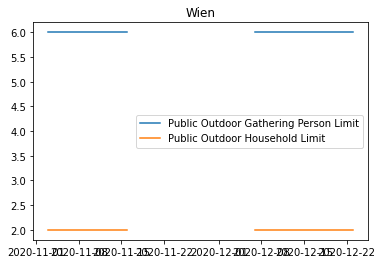

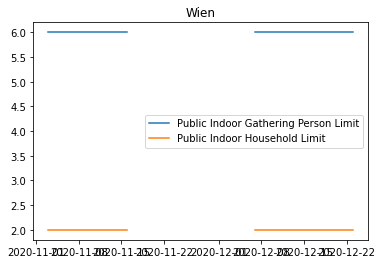

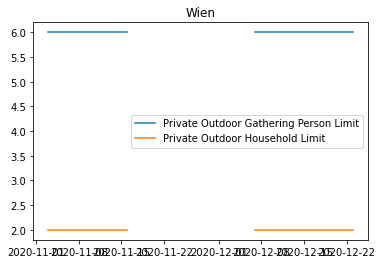

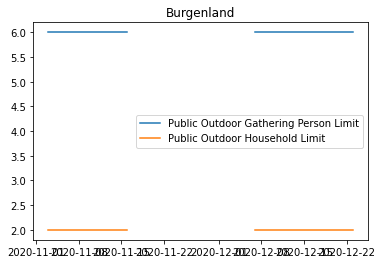

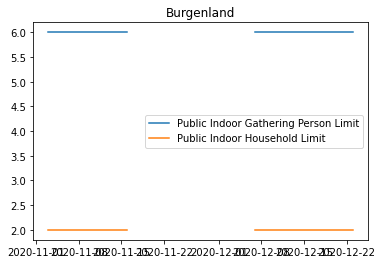

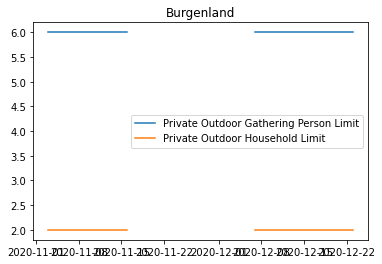

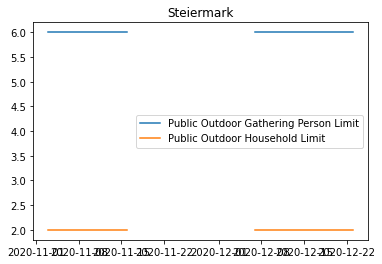

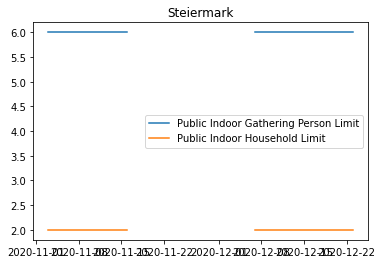

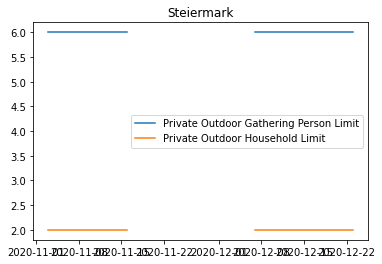

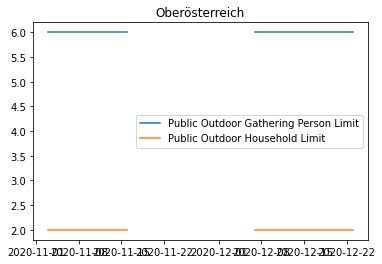

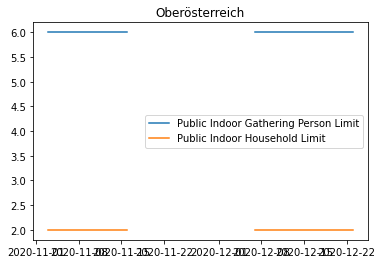

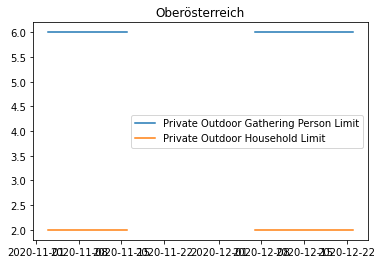

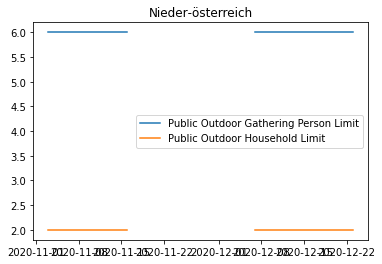

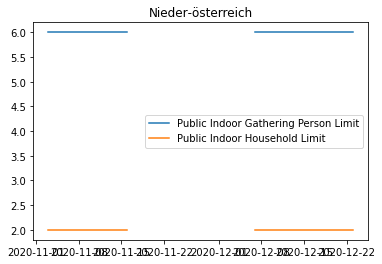

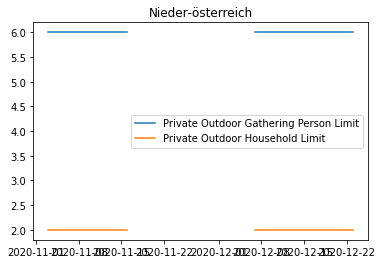

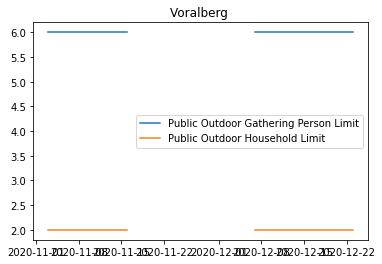

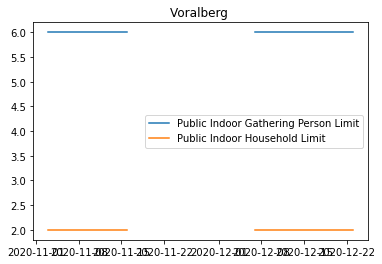

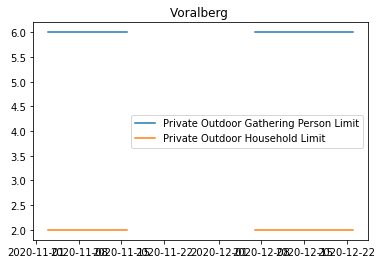

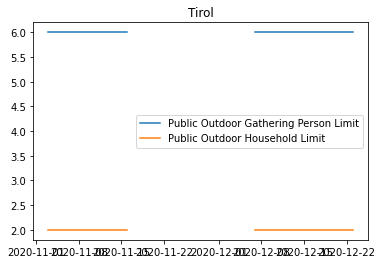

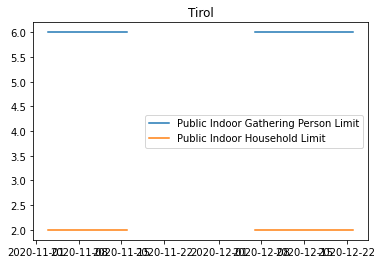

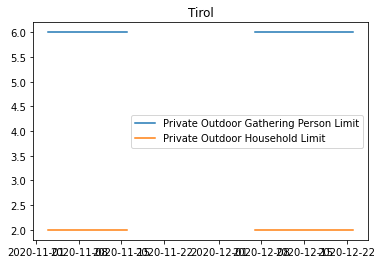

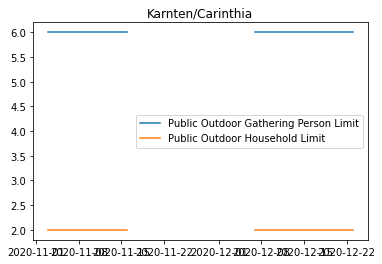

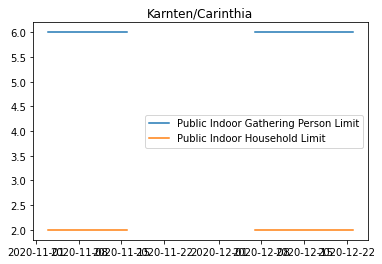

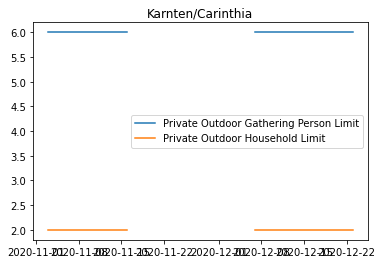

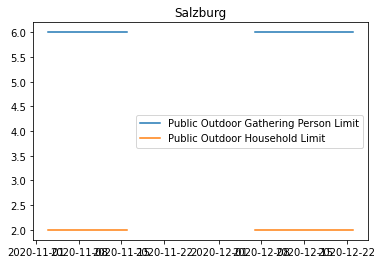

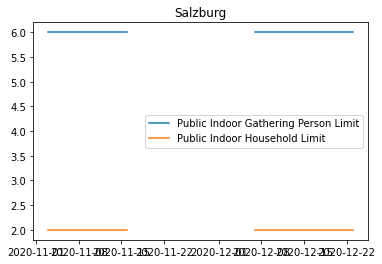

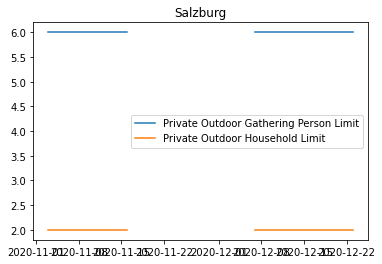

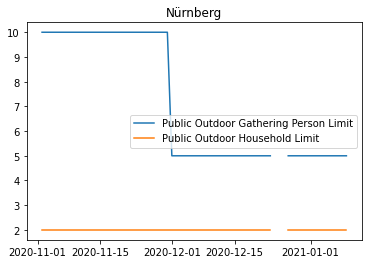

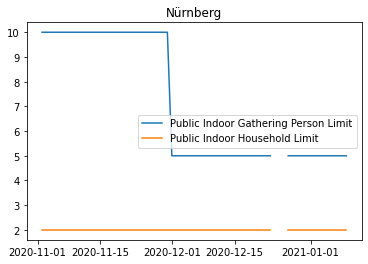

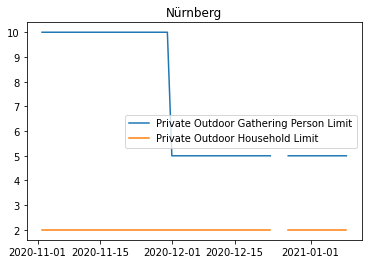

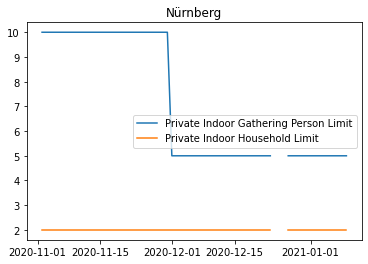

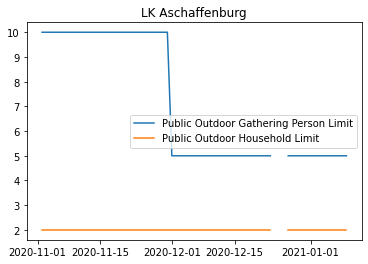

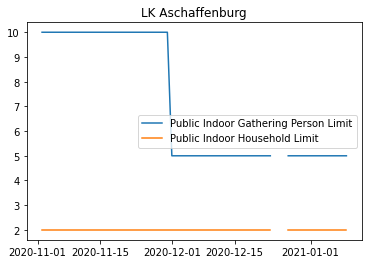

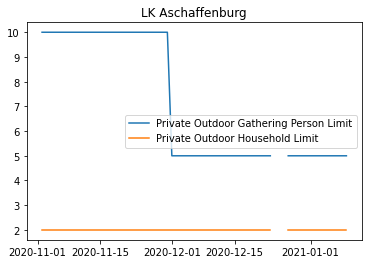

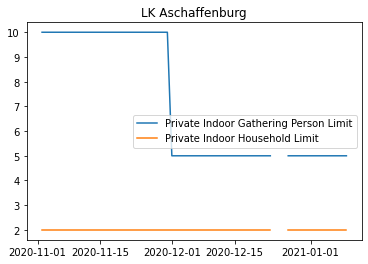

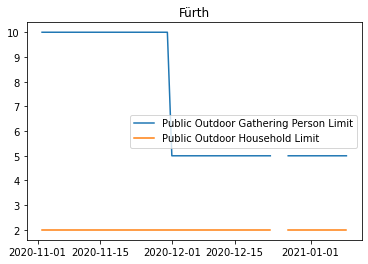

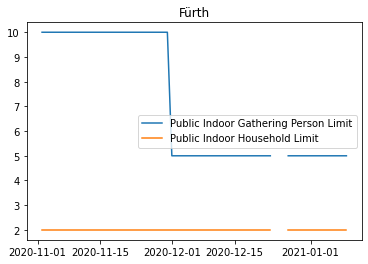

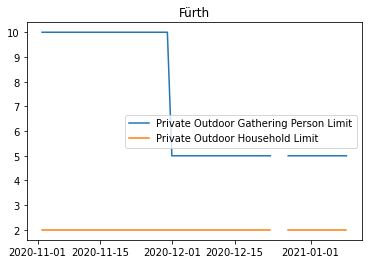

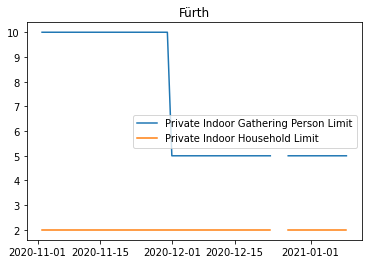

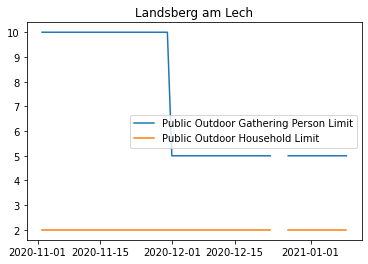

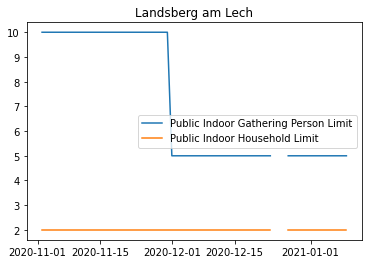

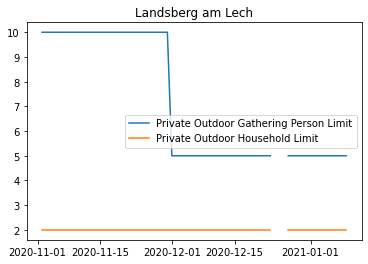

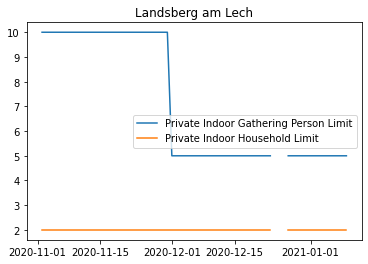

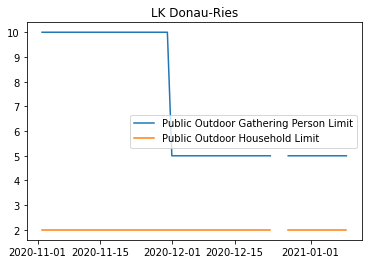

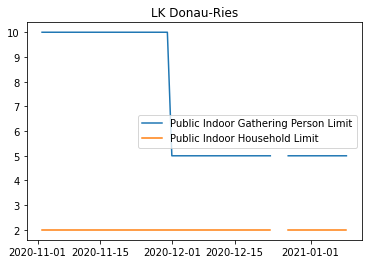

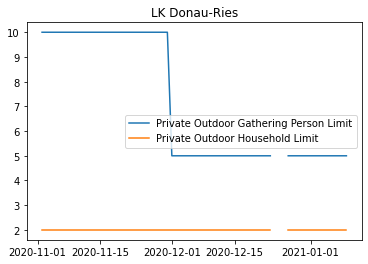

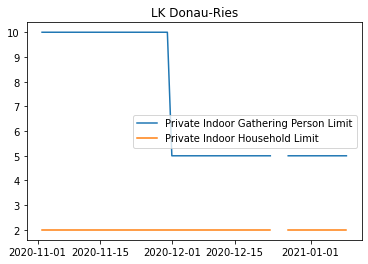

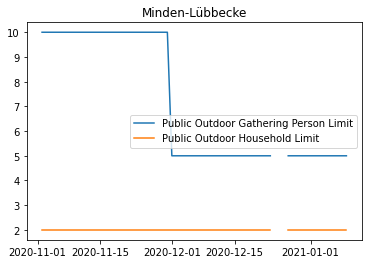

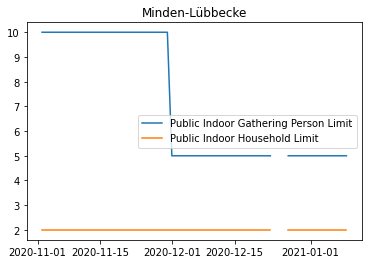

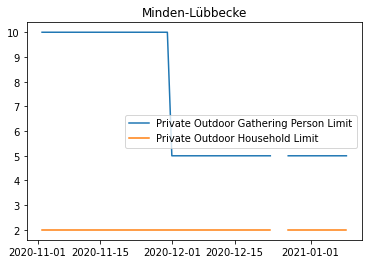

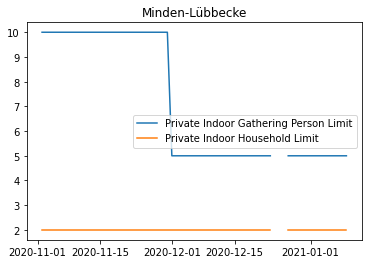

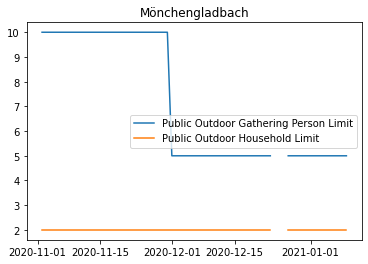

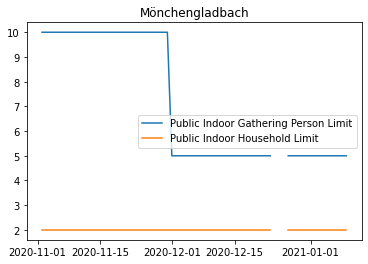

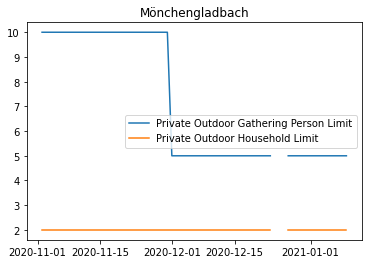

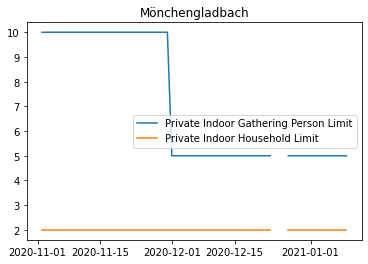

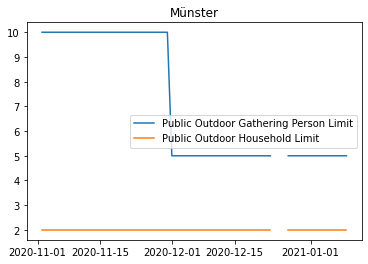

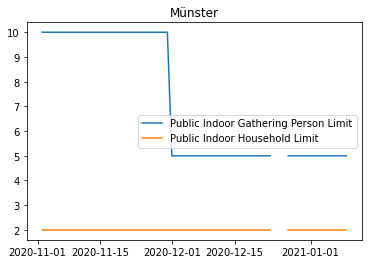

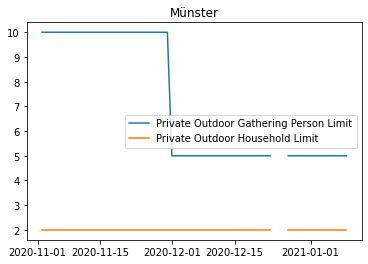

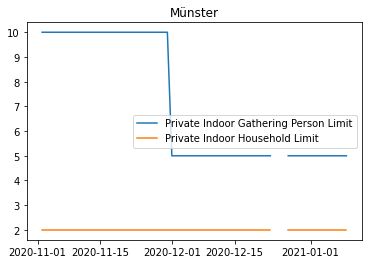

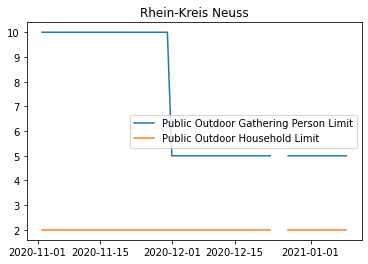

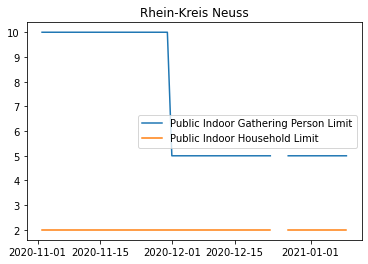

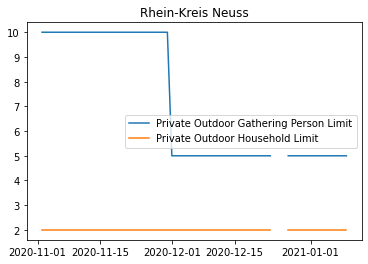

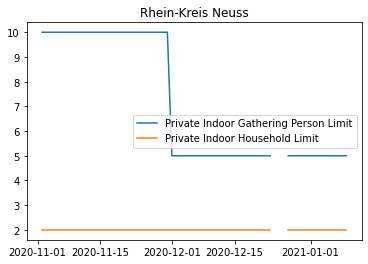

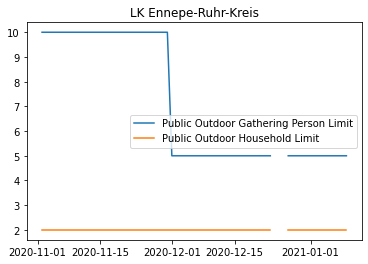

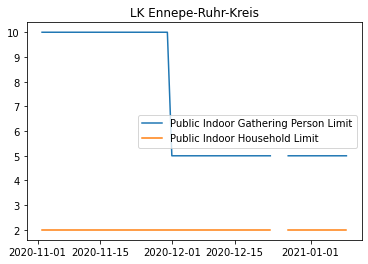

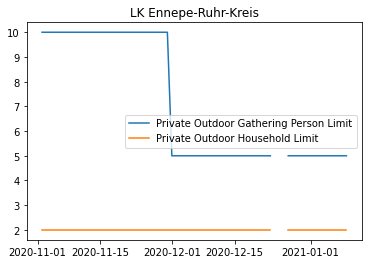

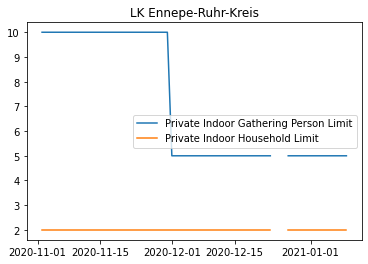

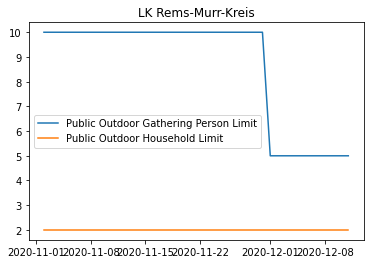

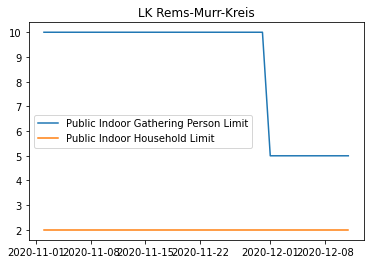

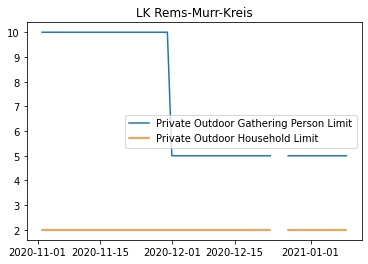

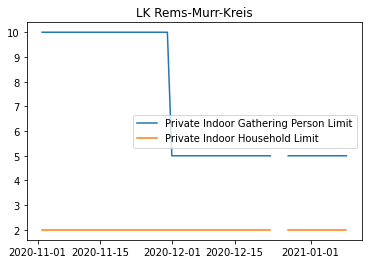

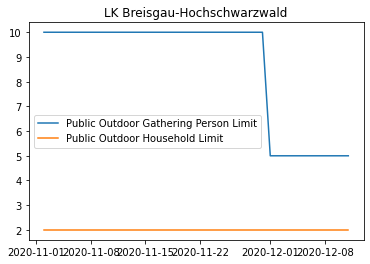

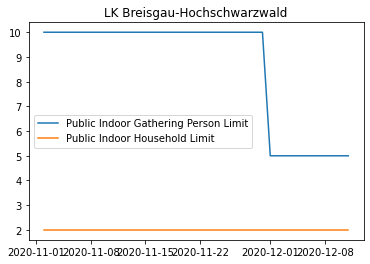

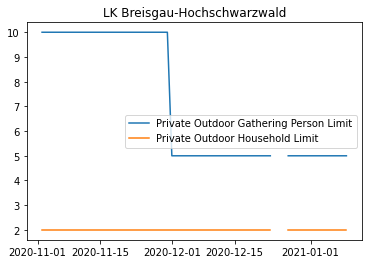

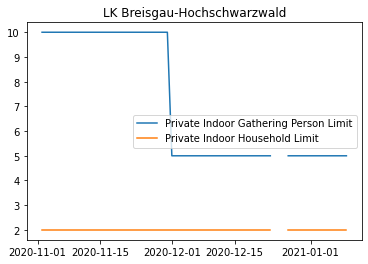

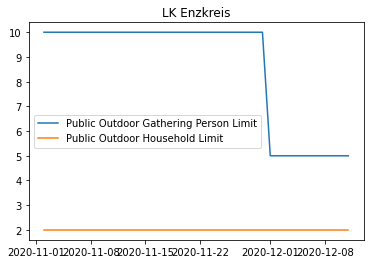

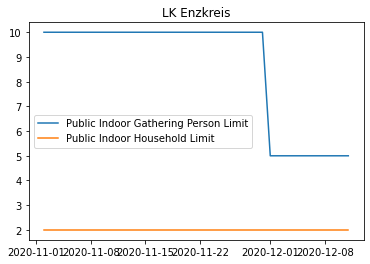

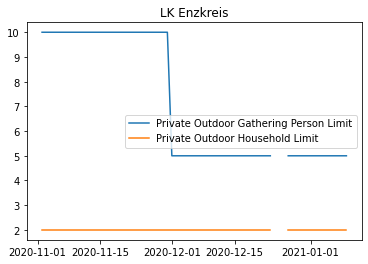

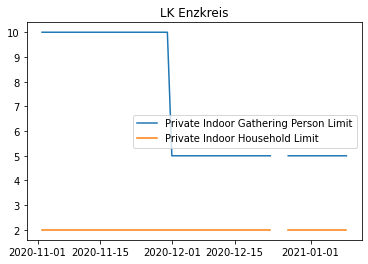

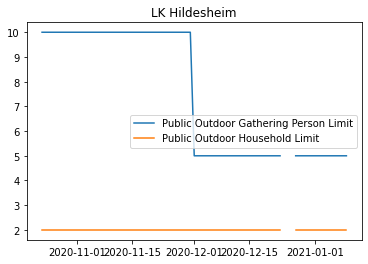

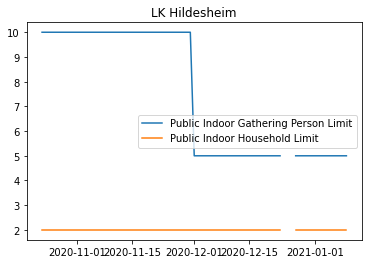

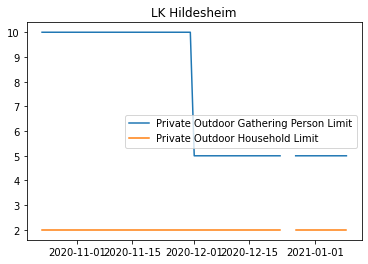

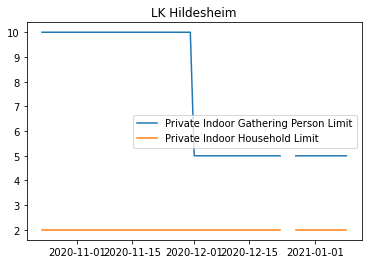

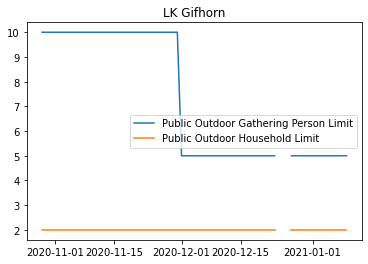

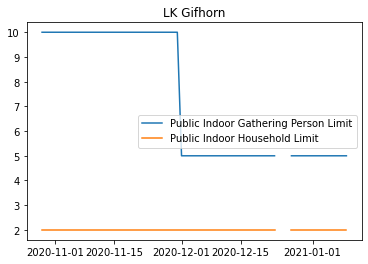

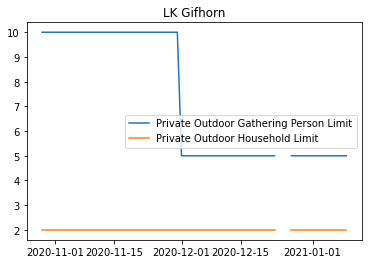

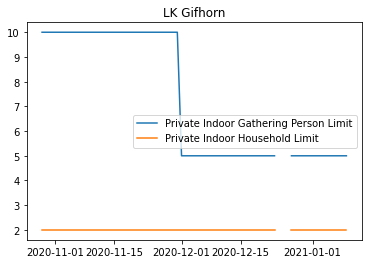

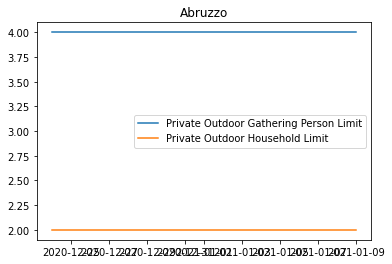

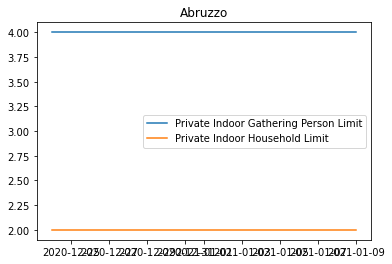

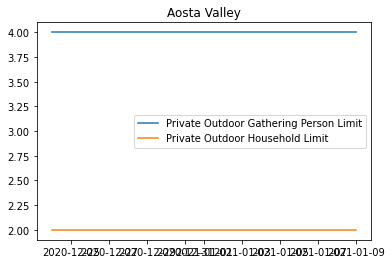

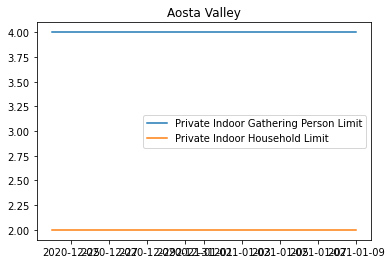

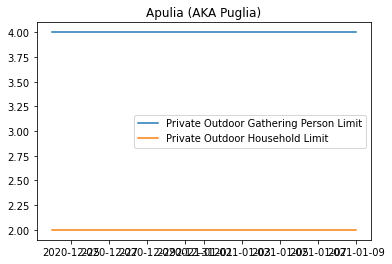

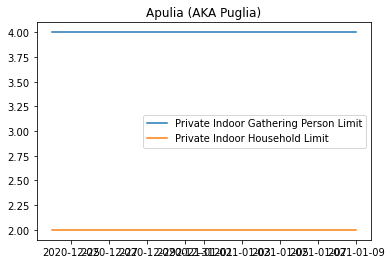

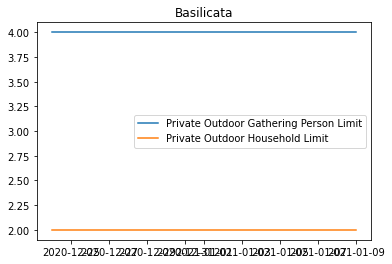

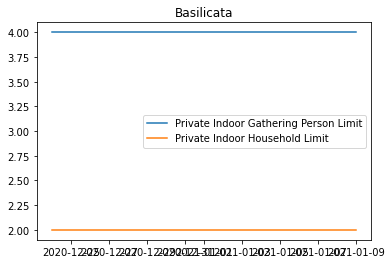

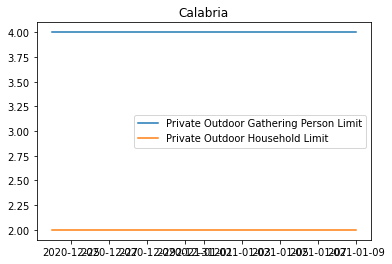

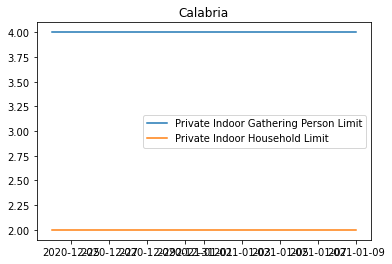

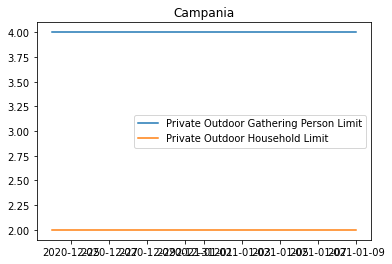

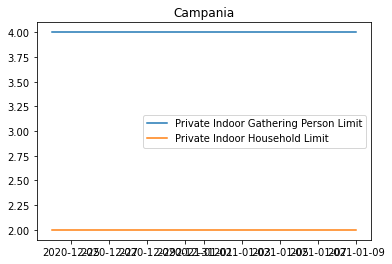

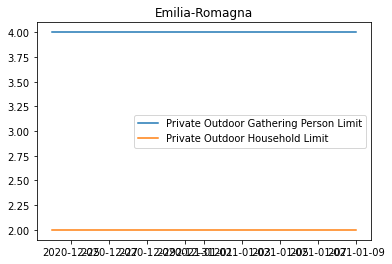

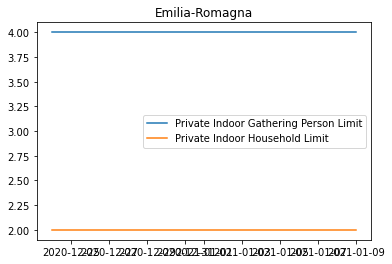

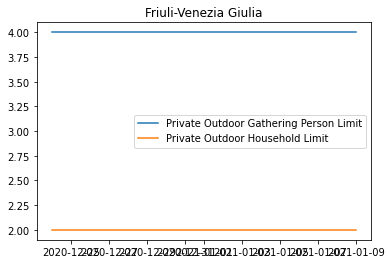

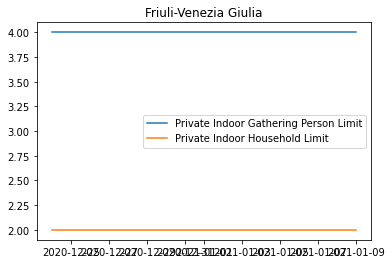

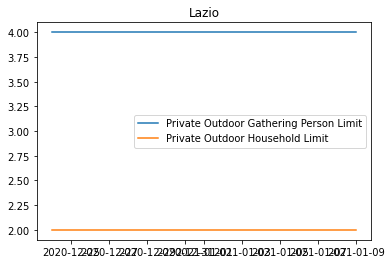

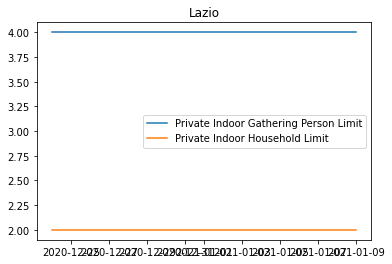

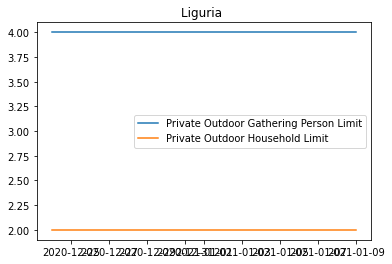

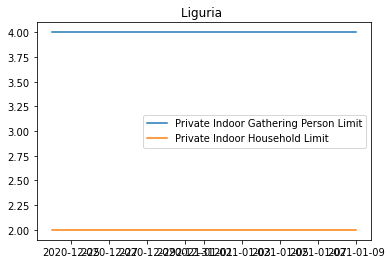

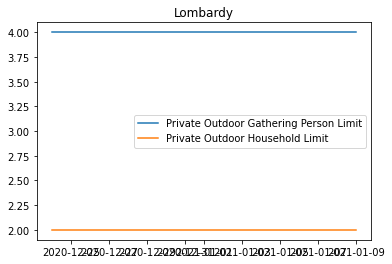

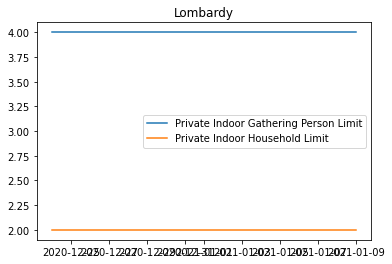

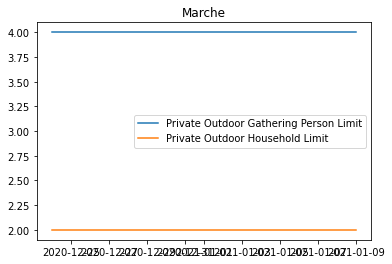

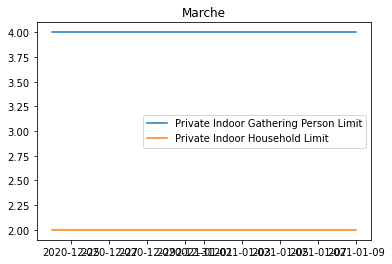

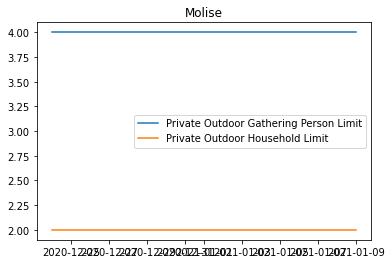

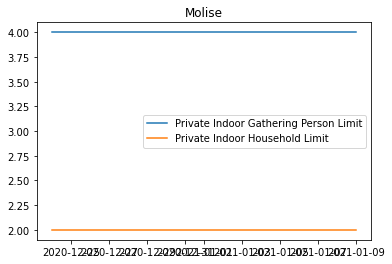

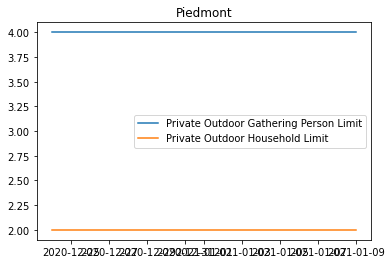

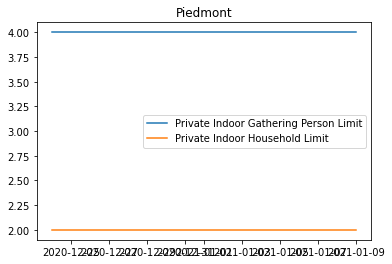

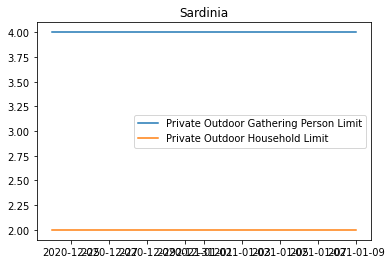

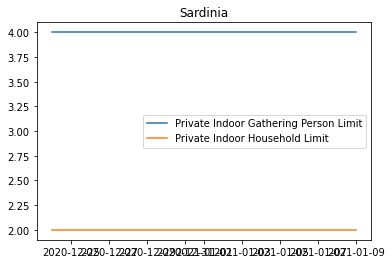

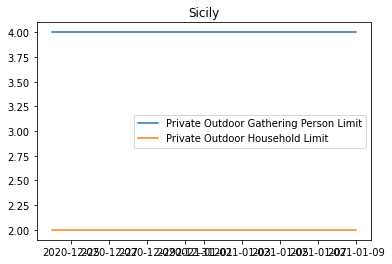

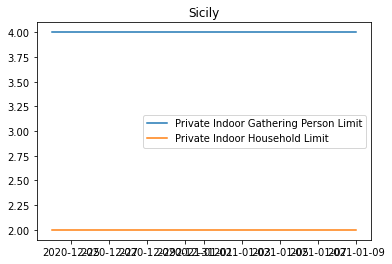

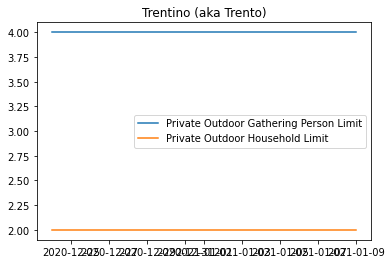

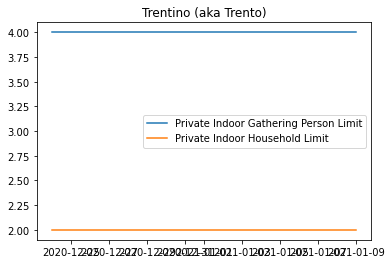

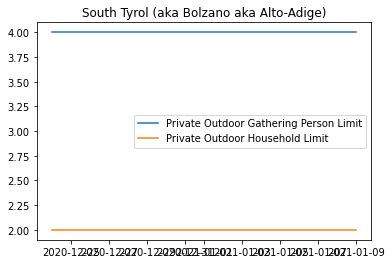

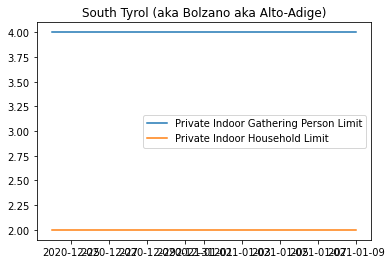

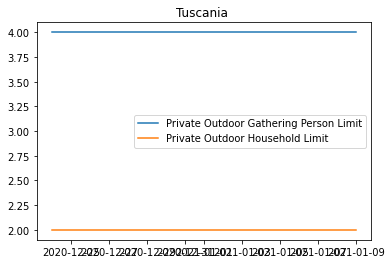

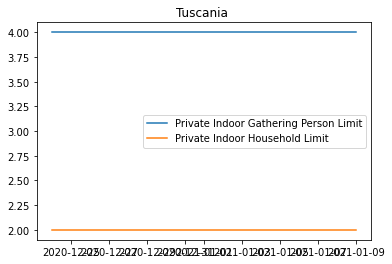

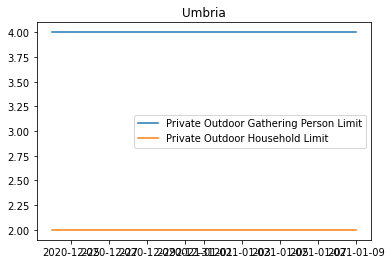

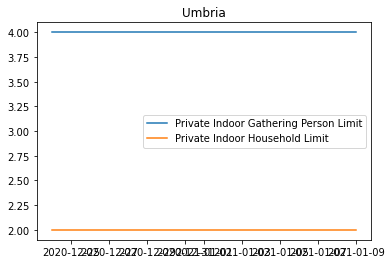

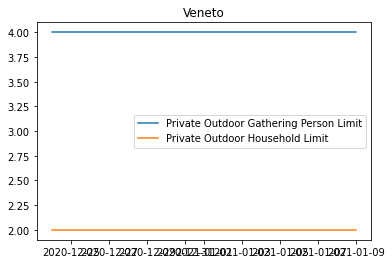

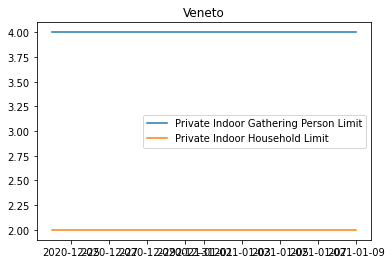

In [47]:
# def plot_timeline_diffs_region(active_CMs, area_indx, Rs, Ds):
#     for i in range(4):
#         CM_gathering_data = active_CMs[area_indx, i, :]
#         CM_household_data = active_CMs[area_indx, i+4, :]
#         if list(CM_gathering_data) != list(CM_household_data):
#             equal_rows = [i for i in range(len(list(CM_gathering_data))) if list(CM_gathering_data)[i] == list(CM_household_data)[i]]
#             CM_gathering_data[equal_rows] = [None for i in range(len(equal_rows))]
#             CM_household_data[equal_rows] = [None for i in range(len(equal_rows))]
#             sns.lineplot(x=Ds, y=list(CM_gathering_data), label = f'{CMs[i]}')
#             sns.lineplot(x=Ds, y=list(CM_household_data), label = f'{CMs[i+4]}')
#             plt.title(f'{Rs[area_indx]}')
#             plt.show()
#
# def plot_timeline_diffs(active_CMs, Rs, Ds):
#     for R in range(len(Rs)):
#         plot_timeline_diffs_region(active_CMs, R, Rs, Ds)
#
# plot_timeline_diffs(active_cms[0], uk_Rs, Ds)
# plot_timeline_diffs(active_cms[1], at_Rs, Ds)
# plot_timeline_diffs(active_cms[2], de_Rs, Ds)
# plot_timeline_diffs(active_cms[3], it_Rs, Ds)
# plot_timeline_diffs(active_cms[4], cz_Rs, Ds)
